# Modelos interpretáveis para a predição de ataques cardíacos

Dataset com 11 parâmetros numéricos e categóricos para prever a ocorrência de um ataque cardíaco.

Gustavo Geyer, Dhruv

In [34]:
import pandas as pd
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np


heart_data = pd.read_csv("./heart_failure_clinical_records_dataset.csv")
# Lista de colunas categóricas que devem ser convertidas para booleanas
bool_columns = ['sex', 'diabetes', 'anaemia', 'high_blood_pressure', 'smoking', 'DEATH_EVENT']

# Conversão explícita para booleano
heart_data[bool_columns] = heart_data[bool_columns].astype(bool)
# a coluna "time" não contribui para a predição
heart_data = heart_data.drop(columns="time")

target_name = "DEATH_EVENT"
y = heart_data[target_name]

x = heart_data.drop(columns=[target_name])

Aqui, mapeamos colunas binárias em valores booleanos. Para a coluna 'sexo', assumimos um binário de 0 para gênero feminino e 1 para masculino.

In [35]:
x

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking
0,75.0,False,582,False,20,True,265000.00,1.9,130,True,False
1,55.0,False,7861,False,38,False,263358.03,1.1,136,True,False
2,65.0,False,146,False,20,False,162000.00,1.3,129,True,True
3,50.0,True,111,False,20,False,210000.00,1.9,137,True,False
4,65.0,True,160,True,20,False,327000.00,2.7,116,False,False
...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,False,61,True,38,True,155000.00,1.1,143,True,True
295,55.0,False,1820,False,38,False,270000.00,1.2,139,False,False
296,45.0,False,2060,True,60,False,742000.00,0.8,138,False,False
297,45.0,False,2413,False,38,False,140000.00,1.4,140,True,True


In [36]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    bool   
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    bool   
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    bool   
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    bool   
 10  smoking                   299 non-null    bool   
dtypes: bool(5), float64(3), int64(3)
memory usage: 15.6 KB


## Seleção Baseada em tipo de dados

No próximo bloco de código vamos aplicar uma abordagem simplista, utilizaremos o dtype das colunas para identificar as variáveis que são categóricas e as variáveis que são numéricas.

In [37]:
from sklearn.compose import make_column_selector as selector

numerical_columns_selector = selector(dtype_exclude=bool)
categorical_columns_selector = selector(dtype_include=bool)

numerical_columns = numerical_columns_selector(x)
categorical_columns = categorical_columns_selector(x)

In [38]:
numerical_columns

['age',
 'creatinine_phosphokinase',
 'ejection_fraction',
 'platelets',
 'serum_creatinine',
 'serum_sodium']

In [39]:
categorical_columns

['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']

## Dispatch de colunas para processos distintos

Como as colunas categóricas são binárias, não precisamos usar one-hot encoding, pois já realizamos o pré-processamento por manualmente associando booleans a essas colunas. Utilizamos apenas um Scaler padrão para normalizar as variáveis numéricas

In [40]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

#categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

Depois passamos para o ColumnTransformer

In [41]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('standard-scaler', numerical_preprocessor, numerical_columns)])

Aqui vamos diretamente associar os modelos a pipelines para normalização.

In [42]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline

knn = make_pipeline(preprocessor, KNeighborsClassifier())
naive = make_pipeline(preprocessor, GaussianNB())
tree = make_pipeline(preprocessor, DecisionTreeClassifier(random_state=42))

modelos = {
    "KNN": knn,
    "Naive Bayes": naive,
    "Decision Tree": tree
}


O código abaixo só mostra o modelo em forma gráfica. Normalmente não fazemos isso na prática, mas enquanto estamos aprendendo pode ajudar a compreender o que é o pipeline.

In [43]:
from sklearn import set_config
set_config(display='diagram')
knn
naive
tree

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standard-scaler',
                                                  StandardScaler(),
                                                  ['age',
                                                   'creatinine_phosphokinase',
                                                   'ejection_fraction',
                                                   'platelets',
                                                   'serum_creatinine',
                                                   'serum_sodium'])])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

Utilizamos o método Stratified K-fold do sklearn para ter uma visão geral de diferentes estimativas de modelos por validação cruzada. Vamos, então, aprofundar a validação em cada modelo.

In [44]:
# Validação cruzada k-fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("\nResultados com validação cruzada (5-fold):")

for nome, modelo in modelos.items():
    scores = cross_val_score(modelo, x, y, cv=cv, scoring='accuracy')
    print(f"\nModelo: {nome}")
    print(f"Acurácia média: {scores.mean():.4f}")
    print(f"Desvio padrão: {scores.std():.4f}")


Resultados com validação cruzada (5-fold):

Modelo: KNN
Acurácia média: 0.7458
Desvio padrão: 0.0554

Modelo: Naive Bayes
Acurácia média: 0.7190
Desvio padrão: 0.0428

Modelo: Decision Tree
Acurácia média: 0.6457
Desvio padrão: 0.0497


### Árvore de Decisão

In [45]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42)

Accuracy: 0.7333333333333333
F1: 0.717978848413631
Precision: 0.728937728937729
Recall: 0.7142857142857143


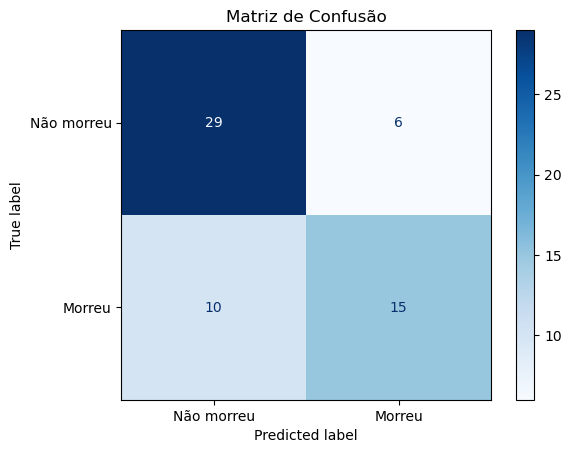

[Text(0.6097261235955056, 0.9666666666666667, 'standard-scaler__serum_creatinine <= 0.431\ngini = 0.418\nsamples = 239\nvalue = [168, 71]\nclass = Vivo'),
 Text(0.35428370786516855, 0.9, 'standard-scaler__ejection_fraction <= -0.496\ngini = 0.331\nsamples = 201\nvalue = [159, 42]\nclass = Vivo'),
 Text(0.4820049157303371, 0.9333333333333333, 'True  '),
 Text(0.11797752808988764, 0.8333333333333334, 'standard-scaler__serum_creatinine <= -0.44\ngini = 0.491\nsamples = 53\nvalue = [30, 23]\nclass = Vivo'),
 Text(0.0449438202247191, 0.7666666666666667, 'standard-scaler__age <= 0.037\ngini = 0.165\nsamples = 11\nvalue = [10, 1]\nclass = Vivo'),
 Text(0.02247191011235955, 0.7, 'gini = 0.0\nsamples = 10\nvalue = [10, 0]\nclass = Vivo'),
 Text(0.06741573033707865, 0.7, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]\nclass = Morto'),
 Text(0.19101123595505617, 0.7666666666666667, 'standard-scaler__creatinine_phosphokinase <= -0.417\ngini = 0.499\nsamples = 42\nvalue = [20, 22]\nclass = Morto'),
 Text

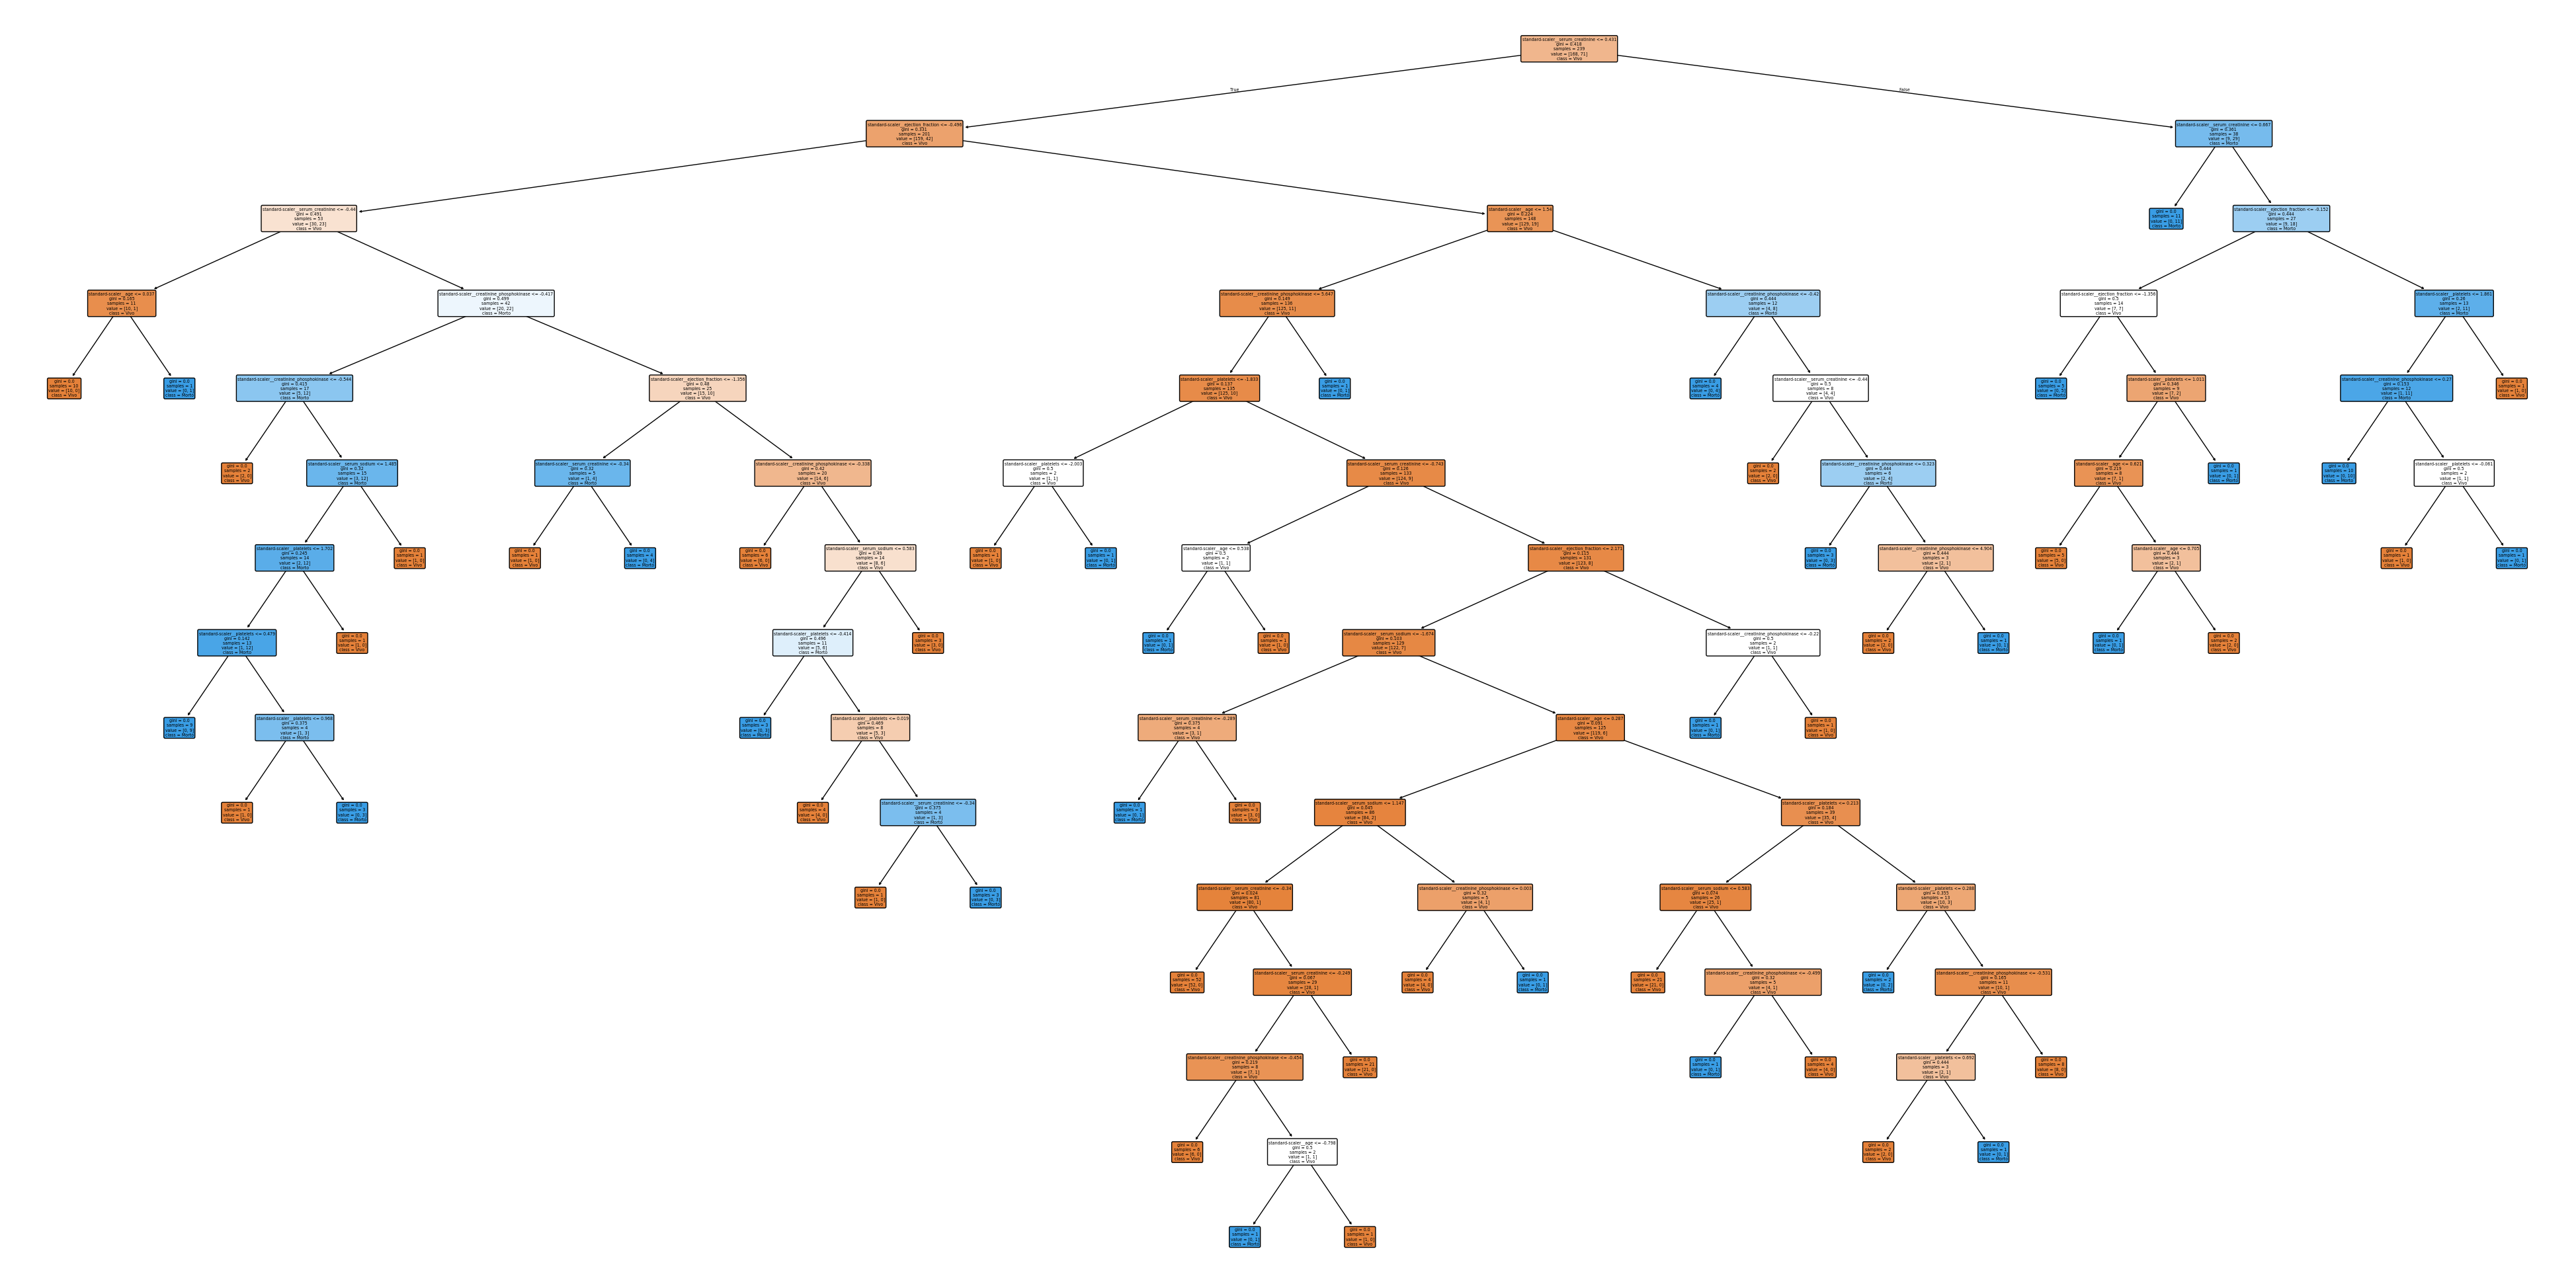

In [46]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

tree.fit(x_train, y_train)
y_pred = tree.predict(x_test)
acc = tree.score(x_test, y_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1:', f1_score(y_test, y_pred, average='macro'))
print('Precision:', precision_score(y_test, y_pred, average='macro'))
print('Recall:', recall_score(y_test, y_pred, average='macro'))


cm = confusion_matrix(y_test, y_pred, labels=[False, True])
ConfusionMatrixDisplay(cm, display_labels=["Não morreu", "Morreu"]).plot(cmap=plt.cm.Blues)
plt.title(f"Matriz de Confusão")
plt.show()

from sklearn.tree import plot_tree
tree_model = tree.named_steps['decisiontreeclassifier']

plt.figure(figsize=(50,25))

plot_tree(tree_model,
          feature_names=tree.named_steps['columntransformer'].get_feature_names_out(),
          class_names=["Vivo", "Morto"],
          filled=True,
          rounded=True)


### KNN
incompleto - utilizar shap e gridcv para validação cruzada e interpretação do KNN.

Fazer a mesma validação cruzada para naive bayes

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_neighbors': range(3,30),
    'weights': ['uniform', 'distance'],
    'p': [1,2] # 1 para Minkowski, 2 para dist. euclidiana (de acordo com a documentação). Vale testar os dois.
}

knn_grid = GridSearchCV(KNeighborsClassifier(), params, n_jobs=-1, scoring='recall')
knn_grid.fit(x_train, y_train)

print(f"Melhores parâmetros: {knn_grid.best_params_}")
print(f"Melhor CV: {knn_grid.best_score_}")

Melhores parâmetros: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Melhor CV: 0.28095238095238095


In [48]:
#best_knn  = knn_grid.best_estimator_
best_knn = make_pipeline(preprocessor, KNeighborsClassifier(n_neighbors=3, p=1, weights='distance'))
best_knn.fit(x_train, y_train)
y_hat = best_knn.predict(x_test)

print("Acurácia: ", accuracy_score(y_test, y_hat))
print("F1: ", f1_score(y_test, y_hat, average='macro'))
print("Precisão: ", precision_score(y_test, y_hat, average='macro'))
print("Recall: ", recall_score(y_test, y_hat, average='macro'))

Acurácia:  0.7166666666666667
F1:  0.6571428571428571
Precisão:  0.79
Recall:  0.6657142857142857


No próximo bloco de código temos a função *score*. É talvez a forma mais simplista 
de avaliar um classificador. Usando a acurácia.

In [49]:
best_knn.score(x_test,y_test)

0.7166666666666667

No próximo bloco fazemos um plot da matriz de confusão e printamos também
um relatório de classificação que contém as principais métricas de classificadores.

              precision    recall  f1-score   support

       False       0.68      0.97      0.80        35
        True       0.90      0.36      0.51        25

    accuracy                           0.72        60
   macro avg       0.79      0.67      0.66        60
weighted avg       0.77      0.72      0.68        60



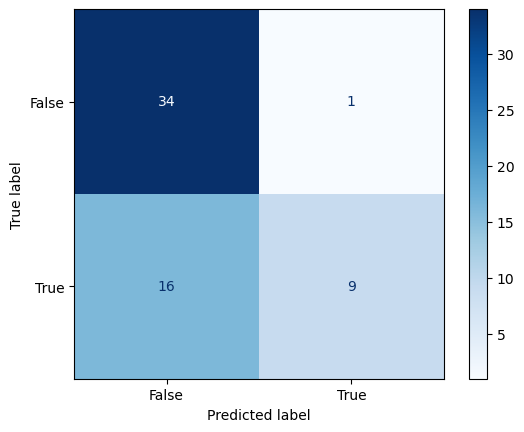

In [50]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_hat, labels=best_knn.classes_)
display_confusion_matrix = ConfusionMatrixDisplay(cm, display_labels=best_knn.classes_)
display_confusion_matrix.plot(cmap=plt.cm.Blues)
print(classification_report(y_test, y_hat))

Neste jupyter notebook nós usamos:

* `ColumnTransformer` para aplicar diferentes pré-processamentos em dados numéricos e categóricos;
* usamos o Pipeline para encadear o `ColumnTransformer` com o kNN;

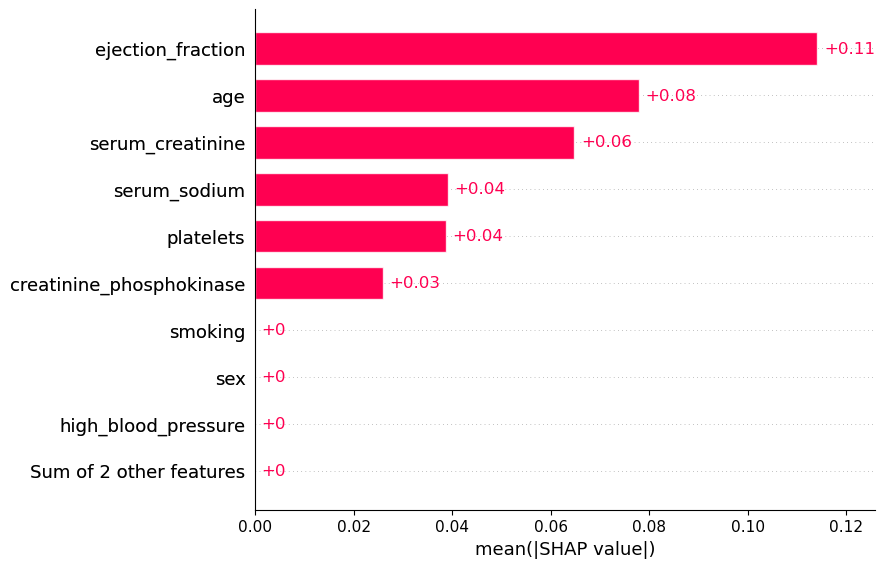

In [51]:
import shap

def predict_fn(x):
    return best_knn.predict_proba(x)[:, 1]


explainer = shap.Explainer(predict_fn, x_train.astype(float))
shap_values = explainer(x_test.astype(float).iloc[0:1000, :])
shap.plots.bar(shap_values)

### Tá explicado porque temos um certo gargalo de escores. O dataset é meio estranho, com várias features tendo peso praticamente nulo

# Naïve Bayes
Vamos tentar usar o método multinomial também para comparação. Aqui, usamos um preprocessador com o MinMax scaler para o NB multinomial, pois o Standard scaler acaba produzindo alguns valores negativos, o que não é compatível com o modelo multinomial.

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

preprocessor_minmax = ColumnTransformer([
    ('minmax-scaler', MinMaxScaler(), numerical_columns)
])

gnb_params = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

mnnb_params = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0],
    'fit_prior': [True, False]
}

mnnb_grid = GridSearchCV(MultinomialNB(), mnnb_params, cv=cv, scoring='accuracy')
gnb_grid = GridSearchCV(GaussianNB(), gnb_params, cv=cv, scoring='accuracy')
gnb_grid.fit(x_train, y_train)
mnnb_grid.fit(x_train, y_train)

print("Melhores parâmetros Gaussiano:", gnb_grid.best_params_)
print("Melhor score CV Gaussiano:", gnb_grid.best_score_)

print("Melhores parâmetros MN:", mnnb_grid.best_params_)
print("Melhor score CV MN:", mnnb_grid.best_score_)

Melhores parâmetros Gaussiano: {'var_smoothing': 1e-09}
Melhor score CV Gaussiano: 0.7195035460992909
Melhores parâmetros MN: {'alpha': 0.1, 'fit_prior': True}
Melhor score CV MN: 0.5023936170212766


In [57]:

best_gnb = make_pipeline(preprocessor, GaussianNB(var_smoothing=1e-09))
best_gnb.fit(x_train, y_train)
y_hat = best_gnb.predict(x_test)

print("Gaussiano")

print("Acurácia: ", accuracy_score(y_test, y_hat))
print("F1: ", f1_score(y_test, y_hat, average='macro'))
print("Precisão: ", precision_score(y_test, y_hat, average='macro'))
print("Recall: ", recall_score(y_test, y_hat, average='macro'))

print("_____________\n")
print("Multinomial")
best_mnnb = make_pipeline(preprocessor_minmax, MultinomialNB(alpha=0.1, fit_prior=True))
best_mnnb.fit(x_train, y_train)
y_hat = best_mnnb.predict(x_test)


print("Acurácia: ", accuracy_score(y_test, y_hat))
print("F1: ", f1_score(y_test, y_hat, average='macro'))
print("Precisão: ", precision_score(y_test, y_hat, average='macro'))
print("Recall: ", recall_score(y_test, y_hat, average='macro'))


Gaussiano
Acurácia:  0.6166666666666667
F1:  0.5193312434691745
Precisão:  0.6201923076923077
Recall:  0.5571428571428572
_____________

Multinomial
Acurácia:  0.5833333333333334
F1:  0.3684210526315789
Precisão:  0.2916666666666667
Recall:  0.5


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print(f"Melhor score Gaussiano: {best_gnb.score(x_test,y_test)}")
print(f"Melhor score Multinomial: {best_mnnb.score(x_test, y_test)}")

Melhor score Gaussiano: 0.6166666666666667
Melhor score Multinomial: 0.5833333333333334


              precision    recall  f1-score   support

       False       0.62      0.91      0.74        35
        True       0.62      0.20      0.30        25

    accuracy                           0.62        60
   macro avg       0.62      0.56      0.52        60
weighted avg       0.62      0.62      0.56        60



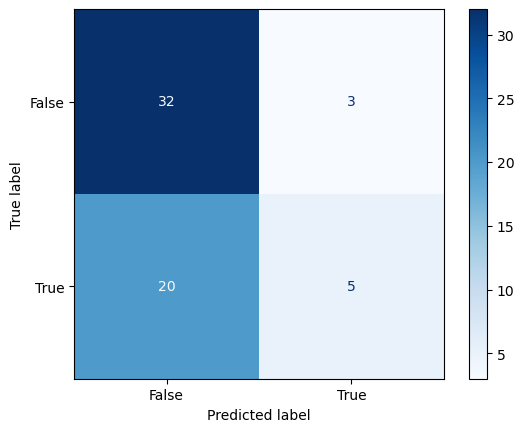

In [ ]:
cm = confusion_matrix(y_test, y_hat, labels=best_gnb.classes_)
display_confusion_matrix = ConfusionMatrixDisplay(cm, display_labels=best_gnb.classes_)
display_confusion_matrix.plot(cmap=plt.cm.Blues)
print(classification_report(y_test, y_hat))
print("_____________________\n")
cm = confusion_matrix(y_test, y_hat, labels=best_mnnb.classes_)
display_confusion_matrix = ConfusionMatrixDisplay(cm, display_labels=best_mnnb.classes_)
display_confusion_matrix.plot(cmap=plt.cm.Blues)
print(classification_report(y_test, y_hat))